In [1]:
### Read files

In [2]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

data["tra"]["visitors"]=np.log1p(data["tra"]["visitors"])
print(len(data["tra"]))


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions a

252108


In [3]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5
def RMSE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [4]:


print(len(data["tra"]))

252108


### Some data categorizing to reduce space

In [5]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hol 0.039612770080566406
tes 2.9315261840820312
hs 1.3301172256469727
as 0.23502159118652344
hr 192.67313385009766
tra 4.38869571685791
id 0.022129058837890625
ar 8.898050308227539
total 210.5182867050171


In [6]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [7]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hol 0.005473136901855469
tes 2.9315261840820312
hs 0.45134544372558594
as 0.09117889404296875
hr 50.57759189605713
tra 4.38869571685791
id 0.022701263427734375
ar 2.313718795776367
total 60.78223133087158


### test

In [8]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type
print(len(data["tes"]))

32019


In [9]:
#print(data["tes"].dtypes)
#data["tes"].head(5)

I add the test dates/stores to the train df

In [10]:
test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra_test"]=data["tra"].append(days_and_stores)

In [11]:
length_train_tot=len(data["tra"])
length_test=len(data["tra_test"])-len(data["tra"])
print(len(days_and_stores))
print(length_train_tot)
print(len(data["tra_test"]))
print(length_test)
#data["tra"]

32019
252108
284127
32019


In [21]:
data["tra_test"]["month"]=data["tra_test"].visit_date.map(lambda x: x.month)
data["tra_test"]["month"]=data["tra_test"]["month"].astype('category')
data["tra_test"]["time_numeric"]=pd.to_numeric(data["tra_test"].visit_date-data["tra_test"].visit_date.min())/1e12
data["tra_test"]["time_numeric"].fillna(0,inplace=True)
data["tra"]     ["time_numeric"]=pd.to_numeric(data["tra"]     .visit_date-data["tra_test"].visit_date.min())/1e12
data["tra"]     ["time_numeric"].fillna(0,inplace=True)
data["tra_test"]["weights"]=np.exp(data["tra_test"]["time_numeric"]/data["tra_test"]["time_numeric"].max())
data["tra"]     ["weights"]=np.exp(data["tra"]     ["time_numeric"]/data["tra_test"]["time_numeric"].max())

### Analysis

In [22]:
cut_date='2017-3-15'

def train_test_eval(df,cut_date):
    df_train=df[df.visitors.notnull()][df["visit_date"]<cut_date]        #train
    df_test= df[df.visitors.notnull()][df["visit_date"]>= cut_date]      #test (I have data to check)
    df_eval= df[df.visitors.isnull()]                                   #eval (for submission only, no data to check)
    for c in df_train.columns:
        if(df_train[c].isnull().any()==True):
            print("warning, null in df_train.",c)
            df_train[c].fillna(0,inplace=True)
    for c in df_test.columns:
        if(df_test[c].isnull().any()==True):
            print("warning, null in df_test.",c)
            df_test[c].fillna(0,inplace=True)
    for c in df_eval.columns:
        if(df_eval[c].isnull().any()==True and c!="visitors"):
            print("warning, null in df_eval.",c)
            df_eval[c].fillna(0,inplace=True)


    return(df_train,df_test,df_eval)

Here I split data["tra"] so that al the averages are only from the training period

In [23]:
datatra_train,datatra_test,_=train_test_eval(data["tra"],cut_date)
assert(length_train_tot==len(datatra_train)+len(datatra_test))
len(datatra_train),len(datatra_test),len(datatra_train)+len(datatra_test)


(224077, 28031, 252108)

Join dataframes

- train + store info

In [24]:
data["tra_as"]=datatra_train.merge(data["as"],on="air_store_id")
data["tra_as"].head()

,air_store_id,visit_date,visitors,time_numeric,weights,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1036.8,1.023528,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,3.496508,1123.2,1.025514,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,3.401197,1209.6,1.027503,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,3.135494,1296.0,1.029496,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,1.945910,1468.8,1.033494,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [25]:
genre_mean_0=pd.DataFrame()
genre_mean_0["genre_mean"]=data["tra_as"].groupby("air_genre_name").visitors.mean()
genre_mean_0["genre_median"]=data["tra_as"].groupby("air_genre_name").visitors.median()
genre_mean_0["genre_min"]=data["tra_as"].groupby("air_genre_name").visitors.min()
genre_mean_0["genre_max"]=data["tra_as"].groupby("air_genre_name").visitors.max()
genre_mean_0["genre_std"]=data["tra_as"].groupby("air_genre_name").visitors.std()
genre_mean_0["genre_wht_mean"]=data["tra_as"].groupby("air_genre_name").apply(lambda x: np.average(x['visitors'], weights=x['weights']))
#genre_mean_0["genre_wht_mean"]=data["tra_as"].groupby("air_genre_name").apply(lambda x: np.average(x['visitors']))
genre_mean_0.fillna(0,inplace=True)
genre_mean_0.reset_index(inplace=True)
genre_mean_0.head()

,air_genre_name,genre_mean,genre_median,genre_min,genre_max,genre_std,genre_wht_mean
0,Asian,3.560563,3.663562,0.693147,4.553877,0.576875,3.533687
1,Bar/Cocktail,2.361171,2.397895,0.693147,6.777647,0.787079,2.354324
2,Cafe/Sweets,2.894337,2.995732,0.693147,6.442540,0.766321,2.888424
3,Creative cuisine,2.911814,2.995732,0.693147,6.244167,0.788548,2.935405
4,Dining bar,2.654155,2.708050,0.693147,5.855072,0.856871,2.644035


In [26]:
area_mean_0=pd.DataFrame()
area_mean_0["area_mean"]=data["tra_as"].groupby("air_area_name").visitors.mean()
area_mean_0["area_median"]=data["tra_as"].groupby("air_area_name").visitors.median()
area_mean_0["area_min"]=data["tra_as"].groupby("air_area_name").visitors.min()
area_mean_0["area_max"]=data["tra_as"].groupby("air_area_name").visitors.max()
area_mean_0["area_std"]=data["tra_as"].groupby("air_area_name").visitors.std()
area_mean_0["area_wht_mean"]=data["tra_as"].groupby("air_area_name").apply(lambda x: np.average(x['visitors'], weights=x['weights']))
area_mean_0.fillna(0,inplace=True)
area_mean_0.reset_index(inplace=True)
area_mean_0.head()

,air_area_name,area_mean,area_median,area_min,area_max,area_std,area_wht_mean
0,Fukuoka-ken Fukuoka-shi Daimyō,2.777006,2.890372,0.693147,6.442540,0.825096,2.770174
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,2.844743,2.890372,0.693147,4.753590,0.751349,2.849632
2,Fukuoka-ken Fukuoka-shi Imaizumi,2.665175,2.772589,0.693147,4.077537,0.623981,2.670048
3,Fukuoka-ken Fukuoka-shi Momochi,2.665447,2.484907,0.693147,4.615121,0.905094,2.652103
4,Fukuoka-ken Fukuoka-shi Shiobaru,2.572548,2.639057,0.693147,5.480639,0.833645,2.561037


- train + day + store info

In [27]:
data["tra_as_hol_0"]=datatra_train.merge(data["as"],on="air_store_id").merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
                    drop("calendar_date",axis=1)
data["tra_as_hol_0"].head()

,air_store_id,visit_date,visitors,time_numeric,weights,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1036.8,1.023528,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,1036.8,1.023528,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,1036.8,1.023528,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,1036.8,1.023528,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,1036.8,1.023528,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Wednesday,0


In [28]:
genre_mean_dow=pd.DataFrame()
genre_mean_dow["genre_mean_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.mean()
genre_mean_dow["genre_median_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.median()
genre_mean_dow["genre_min_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.min()
genre_mean_dow["genre_max_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.max()
genre_mean_dow["genre_std_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.std()
genre_mean_dow["genre_wht_mean_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
genre_mean_dow.fillna(0,inplace=True)
genre_mean_dow.reset_index(inplace=True)
genre_mean_dow.head()

,air_genre_name,day_of_week,genre_mean_dow,genre_median_dow,genre_min_dow,genre_max_dow,genre_std_dow,genre_wht_mean_dow
0,Asian,Friday,3.635023,3.663562,2.302585,4.465908,0.414071,3.616189
1,Asian,Monday,3.443114,3.496508,1.791759,4.553877,0.510177,3.416930
2,Asian,Saturday,3.701610,3.912023,0.693147,4.330733,0.603200,3.673669
3,Asian,Sunday,3.747098,3.951244,2.302585,4.488636,0.593742,3.751326
4,Asian,Thursday,3.421834,3.610553,2.079442,4.174387,0.601997,3.376908


In [29]:
genre_mean_hol=pd.DataFrame()
genre_mean_hol["genre_mean_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.mean()
genre_mean_hol["genre_median_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.median()
genre_mean_hol["genre_min_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.min()
genre_mean_hol["genre_max_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.max()
genre_mean_hol["genre_std_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.std()
genre_mean_hol["genre_wht_mean_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
genre_mean_hol.fillna(0,inplace=True)

genre_mean_hol.reset_index(inplace=True)
genre_mean_hol.head()

,air_genre_name,holiday_flg,genre_mean_hol,genre_median_hol,genre_min_hol,genre_max_hol,genre_std_hol,genre_wht_mean_hol
0,Asian,0,3.562683,3.663562,0.693147,4.553877,0.553147,3.536854
1,Asian,1,3.522412,3.688879,0.693147,4.406719,0.920155,3.476524
2,Bar/Cocktail,0,2.350320,2.397895,0.693147,6.777647,0.782009,2.343346
3,Bar/Cocktail,1,2.538243,2.564949,0.693147,5.129899,0.846516,2.533362
4,Cafe/Sweets,0,2.884122,2.944439,0.693147,6.442540,0.763253,2.878805


In [30]:
area_mean_dow=pd.DataFrame()
area_mean_dow["area_mean_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.mean()
area_mean_dow["area_median_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.median()
area_mean_dow["area_min_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.min()
area_mean_dow["area_max_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.max()
area_mean_dow["area_std_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.std()
area_mean_dow["area_wht_mean_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
area_mean_dow.fillna(0,inplace=True)
area_mean_dow.reset_index(inplace=True)
area_mean_dow.head()

,air_area_name,day_of_week,area_mean_dow,area_median_dow,area_min_dow,area_max_dow,area_std_dow,area_wht_mean_dow
0,Fukuoka-ken Fukuoka-shi Daimyō,Friday,2.849560,2.944439,0.693147,5.786897,0.777735,2.845537
1,Fukuoka-ken Fukuoka-shi Daimyō,Monday,2.639478,2.772589,0.693147,4.553877,0.841171,2.633083
2,Fukuoka-ken Fukuoka-shi Daimyō,Saturday,3.063326,3.178054,0.693147,6.016157,0.763220,3.056865
3,Fukuoka-ken Fukuoka-shi Daimyō,Sunday,2.889574,3.044522,0.693147,4.584967,0.814238,2.881048
4,Fukuoka-ken Fukuoka-shi Daimyō,Thursday,2.682684,2.772589,0.693147,5.786897,0.806185,2.674662


In [31]:
area_mean_hol=pd.DataFrame()
area_mean_hol["area_mean_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.mean()
area_mean_hol["area_median_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.median()
area_mean_hol["area_min_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.min()
area_mean_hol["area_max_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.max()
area_mean_hol["area_std_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.std()
area_mean_hol["area_wht_mean_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
area_mean_hol.fillna(0,inplace=True)
area_mean_hol.reset_index(inplace=True)
area_mean_hol.head()

,air_area_name,holiday_flg,area_mean_hol,area_median_hol,area_min_hol,area_max_hol,area_std_hol,area_wht_mean_hol
0,Fukuoka-ken Fukuoka-shi Daimyō,0,2.767605,2.890372,0.693147,6.442540,0.825865,2.761125
1,Fukuoka-ken Fukuoka-shi Daimyō,1,2.927057,3.044522,0.693147,5.105945,0.798255,2.915609
2,Fukuoka-ken Fukuoka-shi Hakata Ekimae,0,2.839734,2.890372,0.693147,4.753590,0.749609,2.843385
3,Fukuoka-ken Fukuoka-shi Hakata Ekimae,1,2.927249,2.995732,0.693147,4.418841,0.776306,2.951718
4,Fukuoka-ken Fukuoka-shi Imaizumi,0,2.670127,2.772589,0.693147,4.077537,0.623942,2.673292


- train + day info

In [32]:
data["tra_hol"]=datatra_train.merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1)
data["tra_hol"]["month"]=data["tra_hol"].visit_date.map(lambda x: x.month)
data["tra_hol"]["month"]=data["tra_hol"]["month"].astype('category')
data["tra_hol"].head()

,air_store_id,visit_date,visitors,time_numeric,weights,day_of_week,holiday_flg,month
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1036.8,1.023528,Wednesday,0,1
1,air_25e9888d30b386df,2016-01-13,3.091042,1036.8,1.023528,Wednesday,0,1
2,air_fd6aac1043520e83,2016-01-13,3.713572,1036.8,1.023528,Wednesday,0,1
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,1036.8,1.023528,Wednesday,0,1
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,1036.8,1.023528,Wednesday,0,1


In [33]:
store_mean_0=pd.DataFrame()
store_mean_0["store_mean"]=datatra_train.groupby("air_store_id").visitors.mean()
store_mean_0["store_median"]=datatra_train.groupby("air_store_id").visitors.median()
store_mean_0["store_min"]=datatra_train.groupby("air_store_id").visitors.min()
store_mean_0["store_max"]=datatra_train.groupby("air_store_id").visitors.max()
store_mean_0["store_std"]=datatra_train.groupby("air_store_id").visitors.std()
store_mean_0["store_wht_mean"]=datatra_train.groupby("air_store_id").apply(lambda x: np.average(x['visitors'], weights=x['weights']))

store_mean_0.fillna(0,inplace=True)
store_mean_0.reset_index(inplace=True)
store_mean_0.head()


,air_store_id,store_mean,store_median,store_min,store_max,store_std,store_wht_mean
0,air_00a91d42b08b08d9,3.150947,3.276967,0.693147,4.605170,0.576011,3.160674
1,air_0164b9927d20bcc3,2.134073,2.197225,0.693147,3.332205,0.660595,2.130323
2,air_0241aa3964b7f861,2.242803,2.302585,0.693147,3.891820,0.573606,2.225443
3,air_0328696196e46f18,1.920288,1.945910,0.693147,3.737670,0.665346,1.910585
4,air_034a3d5b40d5b1b1,2.351501,2.441401,0.693147,4.762174,0.826814,2.380199


In [34]:
store_mean_dow=pd.DataFrame()
store_mean_dow["store_dow_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.median() #.reset_index()
store_mean_dow["store_dow_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.mean() #.reset_index()
store_mean_dow["store_dow_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.min() #.reset_index()
store_mean_dow["store_dow_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.max() #.reset_index()
store_mean_dow["store_dow_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.std() #.reset_index()
store_mean_dow["store_wht_mean_dow"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
store_mean_dow["store_wht_mean_dow"].fillna(store_mean_0["store_wht_mean"],inplace=True)
store_mean_dow["store_dow_mdn"].fillna(store_mean_0["store_median"],inplace=True)
store_mean_dow["store_dow_mean"].fillna(store_mean_0["store_mean"],inplace=True)
store_mean_dow["store_dow_min"].fillna(store_mean_0["store_min"],inplace=True)
store_mean_dow["store_dow_max"].fillna(store_mean_0["store_max"],inplace=True)
store_mean_dow["store_dow_std"].fillna(store_mean_0["store_std"],inplace=True)
store_mean_dow.fillna(0,inplace=True)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow=store_mean_dow.reset_index() #unstack(level=1)
print(len(store_mean_dow))
store_mean_dow.head()

5726


,air_store_id,day_of_week,store_dow_mdn,store_dow_mean,store_dow_min,store_dow_max,store_dow_std,store_wht_mean_dow
0,air_00a91d42b08b08d9,Friday,3.583519,3.598333,3.044522,4.060443,0.228421,3.595195
1,air_00a91d42b08b08d9,Monday,2.995732,3.025464,0.693147,3.871201,0.531007,3.043298
2,air_00a91d42b08b08d9,Saturday,2.484907,2.551471,1.386294,4.605170,0.682411,2.578446
3,air_00a91d42b08b08d9,Sunday,1.098612,1.098612,1.098612,1.098612,0.000000,1.098612
4,air_00a91d42b08b08d9,Thursday,3.417592,3.378179,2.772589,3.871201,0.254134,3.382500


In [35]:
store_mean_dow_hol=pd.DataFrame()
#store_mean_dow_hol["store_dow_hol_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.median() #.reset_index()
#store_mean_dow_hol["store_dow_hol_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.mean() #.reset_index()
#store_mean_dow_hol["store_dow_hol_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.min() #.reset_index()
#store_mean_dow_hol["store_dow_hol_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.max() #.reset_index()
#store_mean_dow_hol["store_dow_hol_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.std() #.reset_index()

store_mean_dow_hol["store_wht_mean_dow_hol"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
store_mean_dow_hol["store_wht_mean_dow_hol"].fillna(store_mean_dow["store_wht_mean_dow"],inplace=True)

#store_mean_dow_hol["store_dow_hol_mdn"].fillna(store_mean_dow["store_dow_mdn"],inplace=True)
#store_mean_dow_hol["store_dow_hol_mean"].fillna(store_mean_dow["store_dow_mean"],inplace=True)
#store_mean_dow_hol["store_dow_hol_min"].fillna(store_mean_dow["store_dow_min"],inplace=True)
#store_mean_dow_hol["store_dow_hol_max"].fillna(store_mean_dow["store_dow_max"],inplace=True)
#store_mean_dow_hol["store_dow_hol_std"].fillna(store_mean_dow["store_dow_std"],inplace=True)
store_mean_dow_hol=store_mean_dow_hol.fillna(0)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow_hol=store_mean_dow_hol.reset_index() #unstack(level=1)
store_mean_dow_hol.head()

,air_store_id,day_of_week,holiday_flg,store_wht_mean_dow_hol
0,air_00a91d42b08b08d9,Friday,0,3.595195
1,air_00a91d42b08b08d9,Monday,0,3.041970
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.578446
4,air_00a91d42b08b08d9,Sunday,0,1.098612


- Finally put all info together, including test set (train +store info + store mean + day info)

In [36]:
final_df= data["tra_test"].merge(data["hol"],left_on="visit_date",right_on="calendar_date",how="left").\
                    drop("calendar_date",axis=1).\
                    merge(store_mean_dow,on=["air_store_id","day_of_week"],how="left").\
                    merge(store_mean_dow_hol,on=["air_store_id","day_of_week",'holiday_flg'],how="left").\
                    merge(data["as"],on=["air_store_id"],how="left").\
                    merge(store_mean_0,on=["air_store_id"],how="left") .\
                    merge(area_mean_0,on=["air_area_name"],how="left").\
                    merge(area_mean_dow,on=["air_area_name","day_of_week"],how="left") .\
                    merge(area_mean_hol,on=["air_area_name","holiday_flg"],how="left") .\
                    merge(genre_mean_hol,on=["air_genre_name","holiday_flg"],how="left").\
                    merge(genre_mean_dow,on=["air_genre_name","day_of_week"],how="left").\
                    merge(genre_mean_0,on=["air_genre_name"],how="left")
final_df["month"]=final_df.visit_date.map(lambda x: x.month)
final_df["month"]=final_df["month"].astype('category')           

print(len(final_df),length_train_tot+length_test)
assert(len(final_df)==length_train_tot+length_test)
for c in final_df.columns:
    if(final_df.isnull().any==True): print(c)
        
final_df.head().T



284127 284127


,0,1,2,3,4
air_store_id,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24
visit_date,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-18 00:00:00
visitors,3.2581,3.49651,3.4012,3.13549,1.94591
month,1,1,1,1,1
time_numeric,1036.8,1123.2,1209.6,1296,1468.8
weights,1.02353,1.02551,1.0275,1.0295,1.03349
day_of_week,Wednesday,Thursday,Friday,Saturday,Monday
holiday_flg,0,0,0,0,0
store_dow_mdn,3.2581,3.09104,3.61092,3.34975,2.56495
store_dow_mean,3.16883,2.96527,3.51538,3.29835,2.61342


One-hot encoding for day of week,month, genre, area

In [37]:
final_df["month"]=final_df["month"].astype('category')
#data["tra_as_hol"].dtypes
cols_to_enc=["month","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(final_df[cols_to_enc])
#data["tra_as_hol"].join(dummies)

enc=final_df.join(dummies)
enc=final_df

enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
#for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)



55


Binary encoder

In [38]:
def f64_to_32(df):
    float_cols=df.select_dtypes(include=["float64"]).columns
    int_cols=df.select_dtypes(include=["int64"]).columns
    for fc in float_cols:
        #print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        #print(ic)
        df[ic]=df[ic].astype("int32")

In [39]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(final_df)

print(sys.getsizeof(enc2)/1024/1024)
f64_to_32(enc2)
print(sys.getsizeof(enc2)/1024/1024)

183.44307231903076
104.32140254974365


Divide train-test before-after

In [40]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
print(len(df_train)+len(df_test),len(df_eval))
assert(len(df_train)+len(df_test)==length_train_tot)
assert(len(df_eval==length_test))

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


warning, null in df_test. store_dow_mdn
warning, null in df_test. store_dow_mean
warning, null in df_test. store_dow_min
warning, null in df_test. store_dow_max
warning, null in df_test. store_dow_std
warning, null in df_test. store_wht_mean_dow
warning, null in df_test. store_wht_mean_dow_hol
warning, null in df_eval. store_dow_mdn
warning, null in df_eval. store_dow_mean
warning, null in df_eval. store_dow_min
warning, null in df_eval. store_dow_max


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


warning, null in df_eval. store_dow_std
warning, null in df_eval. store_wht_mean_dow
warning, null in df_eval. store_wht_mean_dow_hol
252108 32019


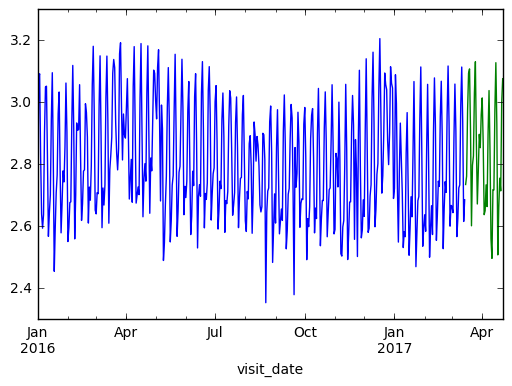

In [41]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [42]:
print(
len(final_df["air_area_name"].unique()),
len(final_df["longitude"].unique()),
len(final_df["latitude"].unique()),
)
print(
len(final_df.groupby(['latitude', 'longitude']).size()),
len(final_df.groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [43]:
df_train.head()

,air_store_id,visit_date,visitors,time_numeric,weights,holiday_flg,store_dow_mdn,store_dow_mean,store_dow_min,store_dow_max,...,genre_min_dow,genre_max_dow,genre_std_dow,genre_wht_mean_dow,genre_mean,genre_median,genre_min,genre_max,genre_std,genre_wht_mean
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1036.8,1.023528,0,3.258097,3.168831,2.197225,4.060443,...,0.693147,5.093750,0.855531,2.558095,2.654155,2.70805,0.693147,5.855072,0.856871,2.644035
1,air_ba937bf13d40fb24,2016-01-14,3.496508,1123.2,1.025514,0,3.091042,2.965269,1.098612,4.007333,...,0.693147,4.663439,0.830187,2.573160,2.654155,2.70805,0.693147,5.855072,0.856871,2.644035
2,air_ba937bf13d40fb24,2016-01-15,3.401197,1209.6,1.027503,0,3.610918,3.515376,1.609438,4.127134,...,0.693147,4.890349,0.823287,2.819868,2.654155,2.70805,0.693147,5.855072,0.856871,2.644035
3,air_ba937bf13d40fb24,2016-01-16,3.135494,1296.0,1.029496,0,3.349750,3.298353,1.945910,3.988984,...,0.693147,5.176150,0.818861,2.959166,2.654155,2.70805,0.693147,5.855072,0.856871,2.644035
4,air_ba937bf13d40fb24,2016-01-18,1.945910,1468.8,1.033494,0,2.564949,2.613419,1.098612,3.555348,...,0.693147,5.855072,0.827634,2.409326,2.654155,2.70805,0.693147,5.855072,0.856871,2.644035


In [44]:
def xy_train_test(df_train,df_test):
    try:
        X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
        X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    except:
        #try:
            X_train = df_train.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
            X_test =  df_test.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
        #except: 
        #            try:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #            except:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()"""
    # Split the targets into training/testing sets
    try:
        y_train = df_train["visitors"].values
        y_test =  df_test["visitors"].values
    except:
        y_train = df_train["col_visitors"].values
        y_test =  df_test["col_visitors"].values
        
    #return(X_train,X_test,y_train,y_test)              
    return(X_train.astype("float32"),X_test.astype("float32"),y_train.astype("float32"),y_test.astype("float32"))              


def test(df_train,df_test,regr):
    #print(df_train.columns)

    (X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

    #print(X_train.shape,y_train.shape)
    #print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred_train=np.maximum(0,y_pred_train)
    error=RMSE(y_test, y_pred)
    error_train=RMSE(y_train, y_pred_train)
    print(error,error_train)
    return error,error_train

In [45]:
(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

In [46]:
len(enc.columns),len(enc2.columns)

(55, 75)

In [47]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
for c in df_train.columns:
    if (df_train[c].isnull().any()): print(c)
for c in df_test.columns:
    if (df_test[c].isnull().any()): print(c)
test(df_train,df_test, linear_model.LinearRegression())


df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
for c in df_train.columns:
    if (df_train[c].isnull().any()): print(c)
for c in df_test.columns:
    if (df_test[c].isnull().any()): print(c)        
test(df_train,df_test, linear_model.LinearRegression())

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


warning, null in df_test. store_dow_mdn
warning, null in df_test. store_dow_mean
warning, null in df_test. store_dow_min
warning, null in df_test. store_dow_max
warning, null in df_test. store_dow_std
warning, null in df_test. store_wht_mean_dow
warning, null in df_test. store_wht_mean_dow_hol
warning, null in df_eval. store_dow_mdn
warning, null in df_eval. store_dow_mean
warning, null in df_eval. store_dow_min


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


warning, null in df_eval. store_dow_max
warning, null in df_eval. store_dow_std
warning, null in df_eval. store_wht_mean_dow
warning, null in df_eval. store_wht_mean_dow_hol
0.574665466724 0.501477442864
warning, null in df_test. store_dow_mdn
warning, null in df_test. store_dow_mean
warning, null in df_test. store_dow_min
warning, null in df_test. store_dow_max
warning, null in df_test. store_dow_std
warning, null in df_test. store_wht_mean_dow
warning, null in df_test. store_wht_mean_dow_hol
warning, null in df_eval. store_dow_mdn
warning, null in df_eval. store_dow_mean
warning, null in df_eval. store_dow_min
warning, null in df_eval. store_dow_max
warning, null in df_eval. store_dow_std
warning, null in df_eval. store_wht_mean_dow
warning, null in df_eval. store_wht_mean_dow_hol
0.574260580395 0.501268625175


(0.57426058039469452, 0.50126862517497373)

In [48]:
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)

test(df_train,df_test, linear_model.LinearRegression())
test(df_train,df_test, linear_model.Ridge(alpha=0.001))
test(df_train,df_test, linear_model.Ridge(alpha=0.01))
test(df_train,df_test, linear_model.Ridge(alpha=0.1))
test(df_train,df_test, linear_model.Ridge(alpha=1))
test(df_train,df_test, linear_model.Ridge(alpha=10))
test(df_train,df_test, linear_model.Ridge(alpha=100))
test(df_train,df_test, linear_model.Ridge(alpha=1000))
test(df_train,df_test, linear_model.Ridge(alpha=10000))
test(df_train,df_test, linear_model.Ridge(alpha=100000))
#test(df_train,df_test, linear_model.Lasso(alpha=0.01))

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


warning, null in df_test. store_dow_mdn
warning, null in df_test. store_dow_mean
warning, null in df_test. store_dow_min
warning, null in df_test. store_dow_max
warning, null in df_test. store_dow_std
warning, null in df_test. store_wht_mean_dow
warning, null in df_test. store_wht_mean_dow_hol
warning, null in df_eval. store_dow_mdn
warning, null in df_eval. store_dow_mean


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


warning, null in df_eval. store_dow_min
warning, null in df_eval. store_dow_max
warning, null in df_eval. store_dow_std
warning, null in df_eval. store_wht_mean_dow
warning, null in df_eval. store_wht_mean_dow_hol
0.574260580395 0.501268625175
0.577582620391 0.500513706957


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3691791700409794e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.45930032502406e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


0.577581769018 0.500513647414
0.577576454353 0.500513706957


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.982942604035088e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


0.577483078556 0.500514600108
0.576648476246 0.500530259768
0.573234779011 0.500778724319
0.568990769618 0.501960635593
0.5652485559 0.507756274118
0.570040781796 0.52463187413


(0.57004078179581597, 0.52463187413032808)

In [49]:
#test(df_train,df_test, svm.SVR(C=0.01))
#test(df_train,df_test, svm.SVR(C=0.1))
#test(df_train,df_test, svm.SVR(C=1))
#test(df_train,df_test, svm.SVR(C=10))
#test(df_train,df_test, svm.SVR(C=100))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=5,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.AdaBoostRegressor)
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=17))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=12))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=11))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=9))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=8))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=7))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=17))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=120,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=18))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=180,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=500,max_features="log2",max_depth=15))


0.542106808298 0.41838001844


KeyboardInterrupt: 

In [50]:
from sklearn.model_selection import PredefinedSplit
test_fold=np.append(-np.ones(len(df_train)),np.zeros(len(df_test)))
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)       
for train_index, test_index in ps.split():
    print(len(train_index),len(test_index))
    print(len(df_train),len(df_test))
    print(train_index,test_index)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))
224077 28031
224077 28031
[     0      1      2 ..., 224074 224075 224076] [224077 224078 224079 ..., 252105 252106 252107]


In [51]:
import scipy
from  sklearn.model_selection import RandomizedSearchCV
from sklearn import *
grid=RandomizedSearchCV(ensemble.RandomForestRegressor(), 
                                        param_distributions=
                        {"max_depth": scipy.stats.randint(5,30), 
                         'n_estimators': scipy.stats.randint(50,250),
                        'max_features':('log2','sqrt')},
                                        n_iter=30,verbose=10,cv=ps,scoring="neg_mean_squared_error" )

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)
X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)

grid.fit(X_tot,y_tot)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] max_features=log2, max_depth=26, n_estimators=72 ................


KeyboardInterrupt: 

In [52]:
grid.best_score_,np.sqrt(-grid.best_score_),grid.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [ ]:
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=5))
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=5))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=10))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=10))
#test(df_train,df_test,ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.5, loss="square"))

In [55]:
from xgboost import XGBRegressor
for rate in 0.1,:
    print(rate)
    test(df_train,df_test,XGBRegressor(max_depth=10, learning_rate=rate, n_estimators=50))

0.1


KeyboardInterrupt: 

In [ ]:
def lognuniform(low=0, high=1, size=None, base=10):
    return np.power(base, np.random.uniform(low, high, size))

In [ ]:
import scipy


grid=model_selection.RandomizedSearchCV(XGBRegressor(), 
                                        param_distributions={
                        "max_depth": scipy.stats.randint(2,10), 
                         'n_estimators': scipy.stats.randint(50,400),
                         'learning_rate':lognuniform(low=-1.5,high=-0.5,base=10,size=100),
                        }, 
                                        n_iter=20,verbose=10 ,cv=ps,scoring="neg_mean_squared_error")

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)


grid.fit(X_tot,y_tot)

In [ ]:
grid.best_score_,np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,XGBRegressor(learning_rate=0.1, n_estimators=89,max_depth=5))


## For submission

In [ ]:
df_eval

In [53]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(len(df_train),len(df_test),len(df_train_tot))
    #print(df_train_tot.columns)
    #print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred=np.expm1(y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [ ]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=18),
         "random_f_binary_log.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,XGBRegressor(learning_rate=0.12, n_estimators=300,max_depth=2),
         "xgb_new.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16),
         "forest.csv")
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=7),
#         "forest.csv")

In [ ]:
len(df_train),len(df_test),len(df_eval),len(df_train)+len(df_test),len(data["tra"])

In [58]:
print(len(enc2))
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
assert(len(df_eval)==length_test)
make_csv(df_train,df_test,df_eval,XGBRegressor(learning_rate= 0.074021471771568439, max_depth= 6, n_estimators= 133),
         "xgb_new2.csv")



284127


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


warning, null in df_test. store_dow_mdn
warning, null in df_test. store_dow_mean
warning, null in df_test. store_dow_min
warning, null in df_test. store_dow_max
warning, null in df_test. store_dow_std
warning, null in df_test. store_wht_mean_dow
warning, null in df_test. store_wht_mean_dow_hol
warning, null in df_eval. store_dow_mdn
warning, null in df_eval. store_dow_mean


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


warning, null in df_eval. store_dow_min
warning, null in df_eval. store_dow_max
warning, null in df_eval. store_dow_std
warning, null in df_eval. store_wht_mean_dow
warning, null in df_eval. store_wht_mean_dow_hol
224077 28031 252108
(252108, 70) (252108,)


/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [ ]:
data["hr"]

In [ ]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [ ]:
stores_tes-stores_tra

In [ ]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape

### Time series

In [ ]:
data["tra_as_hol"]

In [ ]:
stores_groups=data["tra_as_hol"].groupby("air_store_id")

In [ ]:
series_test=stores_groups.get_group("air_00a91d42b08b08d9")[["visit_date","visitors"]]
series_test=series_test.set_index(series_test.visit_date).drop("visit_date",axis=1).dropna()
series_test.plot()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series_test, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
model_fit.fittedvalues.plot()
series_test.plot()

### DOW HOL average

In [ ]:
df_train,df_test,df_eval=train_test_eval(data["tra_as_hol"],cut_date)

In [ ]:
def get_y_pred(df_train,df_test):
    mean_store_dow_hol=df_train.groupby(["air_store_id","day_of_week","holiday_flg"]).visitors.mean().reset_index()
    mean_store_dow=df_train.groupby(["air_store_id","day_of_week"]).visitors.mean().reset_index()
    mean_store_hol=df_train.groupby(["air_store_id","holiday_flg"]).visitors.mean().reset_index()
    mean_store=df_train.groupby(["air_store_id"]).visitors.mean().reset_index()
    df_1=df_test.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
    df_2=df_test.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
    df_3=df_test.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
    df_4=df_test.merge(mean_store,on=["air_store_id"],how="left")
    y_pred_1=df_1.visitors_y.values
    y_pred_2=df_2.visitors_y.values
    y_pred_3=df_3.visitors_y.values
    y_pred_4=df_4.visitors_y.values
    y_test=df_1.visitors_x.values
    for i,y in enumerate(y_pred_1):
        if np.isnan(y): 
            if not np.isnan(y_pred_2[i]): y_pred_1[i]=y_pred_2[i]
            else:
                if not np.isnan(y_pred_3[i]): y_pred_1[i]=y_pred_3[i]
                else:
                    if not np.isnan(y_pred_4[i]):y_pred_1[i]=y_pred_4[i]
                    else:y_pred_1[i]=0
    return (y_test,y_pred_1)




y_test,y_pred=get_y_pred(df_train,df_test)
y_train,y_pred_t=get_y_pred(df_train,df_train)

In [ ]:
len(y_test),len(y_pred),len(y_train),len(y_pred_t)

In [ ]:
RMSE(y_train,y_pred_t),RMSE(y_test,y_pred)